In [1]:
import sys
sys.path.append('/reg/neh/home/haoyuan/Documents/my_repos/Arsenal/')

import arsenal
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import time

# Define Some parameters

In [2]:
run_num = 176

# Load the patterns

In [3]:
with h5.File('/reg/d/psdm/amo/amox34117/scratch/haoyuan/experiment_data/amox34117_run_176_selection_based_on_psocake.h5') as h5file:
    # Get batch_num
    batch_num = int(len(list(h5file.keys()))//2)
    
    # Loop through all the batch
    holder = []
    for l in range(batch_num):
        holder.append(np.array(h5file['batch_{}_pattern'.format(l)]))
        
patterns = np.concatenate(holder, axis = 0)

# Load the simulation patterns

In [4]:
with h5.File('/reg/d/psdm/amo/amox34117/scratch/haoyuan/pysingfel/output/exp_simulation_pattern_roi.h5') as h5file:
    # Get batch_number
    batch_num = len(list(h5file.keys()))
    
    holder = []
    for l in range(batch_num):
        holder.append(np.array(h5file['pattern_batch_{}'.format(l)]))
        
distributions = np.concatenate(holder, axis=0)

summation = np.sum(distributions, axis=(1,2))
distributions /= summation[:, np.newaxis, np.newaxis]

# Load the mask

In [5]:
mask_bool = np.load('../../output/mask_2d_bool_roi_round_1.npy')

# Apply the mask to the arrays

In [6]:
pattern_num = patterns.shape[0]
holder = []

for l in range(pattern_num):
    tmp = patterns[l]
    holder.append(tmp[mask_bool])

pattern_masked = np.vstack(holder)

In [7]:
distribution_num = distributions.shape[0]
holder = []

for l in range(distribution_num):
    tmp = distributions[l]
    holder.append(tmp[mask_bool[:, :122]])

distribution_masked = np.vstack(holder)

# Calculate the log likelihood

In [8]:
tic = time.time()

(log_likelihood, 
 orientaion_idx, 
 intensity) = arsenal.stats.log_likelihood_poisson_spi(samples=pattern_masked,
                                                       distributions=distribution_masked)

toc = time.time()
print('It takes {:.2f} seconds to calculate'.format(toc -tic) +
      'the optimal log likelihood for {} patterns versus {} orientations'.format(pattern_masked.shape[0],
                                                                                 distribution_masked.shape[0]))

It takes 19.32 seconds to calculatethe optimal log likelihood for 4230 patterns versus 10860 orientations


# Save the results

In [9]:
with h5.File('../../output/run_{}_log_likelihood.h5'.format(run_num), 'w') as h5file:
    h5file.create_dataset('patterns', data= patterns)
    h5file.create_dataset('patterns_masked', data= pattern_masked)
    h5file.create_dataset('distributions', data= distributions)
    h5file.create_dataset('distribution_masked', data= distribution_masked)
    h5file.create_dataset('log_likelihood', data= log_likelihood)
    h5file.create_dataset('distribution_idx', data= orientaion_idx)
    h5file.create_dataset('intensity', data= intensity)
    h5file.create_dataset('mask', data= mask_bool)

# Visualizing the results

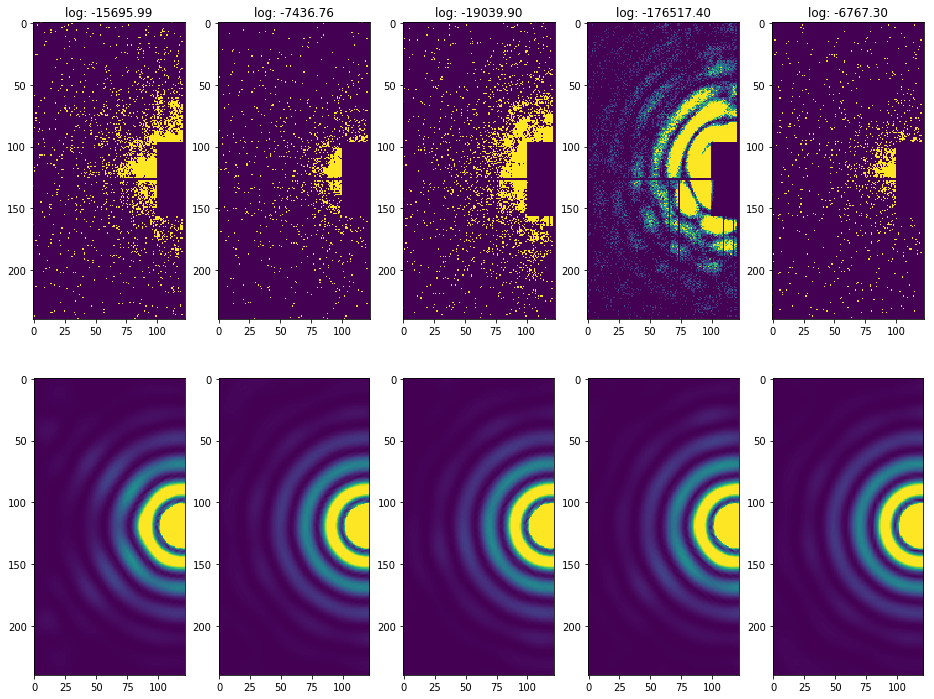

In [10]:
col_num = 5
pat_idx = np.random.permutation(patterns.shape[0])[:col_num]
dis_idx = orientaion_idx[pat_idx]

# Set up the canvas
fig, axes = plt.subplots(nrows=2, ncols=col_num)
fig.set_figheight(12)
fig.set_figwidth(16)

# Plot the patterns
for l in range(col_num):
    axes[1, l].imshow(intensity[pat_idx[l]]* distributions[dis_idx[l]], vmax= intensity[pat_idx[l]]*1e-4)
    axes[0, l].imshow(patterns[pat_idx[l]], vmax=intensity[pat_idx[l]]*1e-4)
    axes[0, l].set_title('log: {:.2f}'.format(log_likelihood[pat_idx[l]]))
    
# Show the canvas
plt.show()

In [29]:
log_likelihood.shape

(4230, 4230)